<p style="font-size:14px; text-align: right">CoastWatch Python Exercises</p>  

# Python Basics: a tutorial for the NOAA Satellite Workshop
> history | updated August 2021  
> owner | NOAA CoastWatch

## In this exercise, you will use Python to download data and metadata from ERDDAP.

### The exercise demonstrates the following skills: 

* Using Python to retrieve information about a dataset from ERDDAP
* Getting data from a remote CSV file
* Downloading satellite data from ERDDAP in netCDF format
* Extracting data with Python

For the examples in this exercise we will use the NOAA GeoPolar Sea Surface temperature  dataset from the CoastWatch West Coast Node (ERDDAP ID = nesdisGeoPolarSSTN5SQNRT).  
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.graph  

The dataset contains monthly composites of SST and has low spatial resolution (0.05 degrees), which will help prevent overloading the local intenet bandwidth during the class.  

### The scripts in this exercise are written in Python 3.7.    

# Get set up
## Import some basic python modules

In [2]:
import pkg_resources


## Look for python modules you might not have installed
We will be using the xarray, numpy, and pandas modules for this exercise. Make sure that they are installed in your Python 3 environment. A quick way to do this is with the script below

In [3]:
# Create a set 'curly brackets' of the modules to look for
# You can put any modules that you want to in the set
required = {'xarray', 'numpy', 'pandas'}

# look for the installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}

# Find which modules are missing
missing = required - installed
if len(missing)==0:
    print('All modules are installed')
else:
    print('These modules are missing', ', '.join(missing))

All modules are installed


#### If you find missing modules, please go to the appendix at the bottom of the page for installation instructions.

## Import the modules

In [4]:
import numpy as np  # for matrix operations
import numpy.ma as ma  # for masking arrays
import pandas as pd  # for tabular data
import xarray as xr  # for gridded data

# Getting information about a dataset 
## First, open a pointer to an ERDDAP dataset, using the xarray `open_dataset` function. 
> xr.open_dataset('full_url_to_erddap_dataset')  

__`'full_url_to_erddap_dataset'` is the full URL to the dataset, which is comprised of:__  
* the base url to the ERDDAP you are using, plus
* the dataset ID.  

### So, for our dataset:    
* base_URL = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap'
* dataset_id = 'nesdisGeoPolarSSTN5SQNRT'
* full_URL = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT'

### Code that works is listed below:   
```python
base_URL = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap'
dataset_id = 'nesdisGeoPolarSSTN5SQNRT'
full_URL = '/'.join([base_URL, dataset_id])
print(full_URL)
da = xr.open_dataset(full_URL)
```

### But, let's put it in a function to make it more versatile

```python
def point_to_dataset(dataset_id, base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap'):
    base_url = base_url.rstrip('/')
    full_url = '/'.join([base_url, dataset_id])
    #print(full_url)
    return xr.open_dataset(full_url)
```

#### Where:  
* dataset_id is the ERDDAP id for the dataset of interest. For this example: 'nesdisGeoPolarSSTN5SQNRT'
* base_url is the url of the ERDDAP you are pulling data from. For this example, the West Coast Node ERDDAP at 'https://coastwatch.pfeg.noaa.gov/erddap/griddap'
* full_url is the full URL to the ERDDAP dataset created by joining base_url and dataset_id
* the pointer to the dataset is returned

The default base_url is the West Coast Node ERDDAP 'https://coastwatch.pfeg.noaa.gov/erddap/griddap'. So, to get your dataset, the function call could be as simple as:
```python
point_to_dataset('nesdisGeoPolarSSTN5SQNRT')
```  
Or you could specify the dataset_id
```python
point_to_dataset(dataset_id = 'nesdisGeoPolarSSTN5SQNRT')
```
You could also specify a different base_url.
```python
point_to_dataset('nesdisGeoPolarSSTN5SQNRT', 'https://upwell.pfeg.noaa.gov/erddap/griddap')

point_to_dataset(dataset_id = 'nesdisGeoPolarSSTN5SQNRT', 
                 base_url = 'https://upwell.pfeg.noaa.gov/erddap/griddap')
```

In [5]:
# Define the function
def point_to_dataset(dataset_id, base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap'):
    base_url = base_url.rstrip('/')
    full_url = '/'.join([base_url, dataset_id])
    #print(full_url)
    return xr.open_dataset(full_url)

# Call the function
da = point_to_dataset('nesdisGeoPolarSSTN5SQNRT')

# uncomment the "da" below to see the full data array info
# da

## Examine the metadata
### Coordinate variables and dimensions
### The code below lists the coordinate variables and their sizes.   
The dataset is a 3D array with:
* 6793 values in the time dimension (as of 4/15/2021 but that increases each day)  
* 3600 values in the latitude dimension
* 7200 values in the longitude dimension


In [6]:
display(da.coords)
display(da.dims)

Coordinates:
  * time       (time) datetime64[ns] 2002-09-01T12:00:00 ... 2021-08-10T12:00:00
  * latitude   (latitude) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

Frozen(SortedKeysDict({'time': 6912, 'latitude': 3600, 'longitude': 7200}))

### Data variables
### The code below lists the data variables. 
There are several variables in the dataset. We are interested in "analysed_sst".

In [7]:
print ('data variables', list(da.keys()))

data variables ['analysed_sst', 'analysis_error', 'sea_ice_fraction', 'mask']


### Global Attributes
#### Global attributes provide information about a dataset as a whole. 

A few of the global attributes are important for you to decide if the dataset will work for your application:  
* "geospatial_lat_min" and "geospatial_lat_max" plus "geospatial_lon_min" and "geospatial_lon_max" give you the geographical range of the dataset.  
* "time_coverage_start" and "time_coverage_end" give you the time range covered by the dataset.
* "geospatial_lat_resolution and geospatial_lon_resolution" give you the spatial resolution

Attributes like "comment", "summary", and "references" can give you more information about how the dataset was generated, how you may use the data, and the people and organizations to acknowledge if you use the data.

The code below lists these global attributes.


In [8]:
print('latitude range:', da.geospatial_lat_min, 'to', da.geospatial_lat_max)
print('longitude range:', da.geospatial_lon_min, 'to', da.geospatial_lon_max)
print('time range:', da.time_coverage_start, 'to', da.time_coverage_end)
print('spatial resolution-degrees:', 
      'lat', np.around(da.geospatial_lat_resolution, decimals=3), 
      'lon', np.around(da.geospatial_lon_resolution, decimals=3) 
     )

print(' ')
print('The dataset summary is below')
print(da.summary)

latitude range: -89.975 to 89.975
longitude range: -179.975 to 179.975
time range: 2002-09-01T12:00:00Z to 2021-08-10T12:00:00Z
spatial resolution-degrees: lat 0.05 lon 0.05
 
The dataset summary is below
This dataset is an aggregation of Science Quality STAR data (2002-2016) and Near Real Time OSPO data (2017-present). Analysed blended sea surface temperature over the global ocean using night only input data. An SST estimation scheme which combines multi-satellite retrievals of sea surface temperature datasets available from polar orbiters, geostationary InfraRed (IR) and microwave sensors into a single global analysis. This global SST ananlysis provide a daily gap free map of the foundation sea surface temperature at 0.05� spatial resolution.


# Download data from ERDDAP

## For this exercise, the area we are interested in includes Monterey Bay, CA:  
* Latitude range: 32N, 39N
* Longitude range: -124E, -117E
* Time range June 3, 2020 to June 7, 2020 

### The Xarray module makes it really easy to request a subset of a dataset using latitude, longitude, and time ranges using:  
* the "sel" method with the "slice" function  

```python
sss=da['analysed_sst'].sel(  
                  latitude=slice(32., 39.),  
                  longitude=slice(-124, -117),  
                  time=slice('2020-06-03T12:00:00', '2020-06-07T12:00:00')  
                 )  
```

__Note: If the dataset had an altitude dimension, then an altitude slice would need to be added to the code, e.g.__  


```python 
                  altitude=slice(0.0), 
)
```

### Let's put it in a function to make it more versatile.   

In [9]:
def get_data(my_da, my_var,
             my_lt_min, my_lt_max, 
             my_ln_min, my_ln_max, 
             my_tm_min, my_tm_max
            ):
    
    my_data = my_da[my_var].sel(
                                latitude=slice(my_lt_min, my_lt_max), 
                                longitude=slice(my_ln_min, my_ln_max), 
                                time=slice(my_tm_min, my_tm_max)
                               )
    return my_data

### Run the function with our geographical and time ranges

In [12]:

lat_min  = 32.
lat_max = 39.
lon_min = -124.
lon_max = -117.
time_min = '2020-06-03T12:00:00'  # written in ISO format
time_max = '2020-06-07T12:00:00'  # written in ISO format
my_var = 'analysed_sst'

sst = get_data(
               da, my_var,
               lat_min, lat_max,
               lon_min, lon_max,
               time_min, time_max
              )

# the sst data array is a subset of da
print(sst.dims)
print('dimension size', sst.shape)

# uncomment the "sst" below to see the full data array info
#sst

('time', 'latitude', 'longitude')
dimension size (5, 140, 140)


## Visualizing the data

### Make a simple plot
Xarray makes it easy to quickly visualize the data as a map.  
* Use the isel method to pick a time slice by its index number 
* Use the imshow method to plot the data
* We have 5 time steps so the index numbers are 0 to 4.  

Plot the first time step:  
```
sst.isel(time=0).plot.imshow()
```

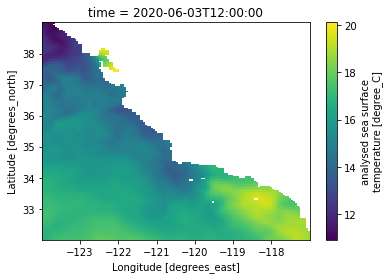

In [13]:
%matplotlib inline
sst.isel(time=0).plot.imshow()

### Use a loop to plot all 5 time steps

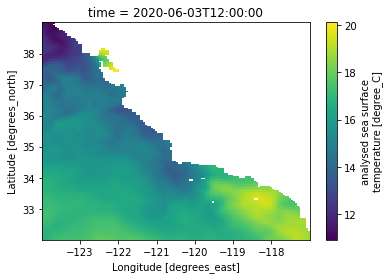

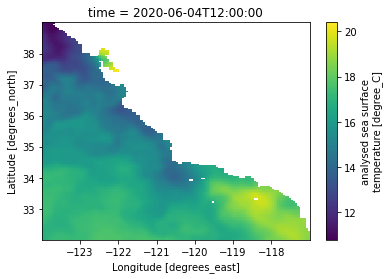

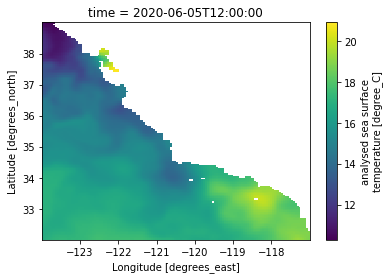

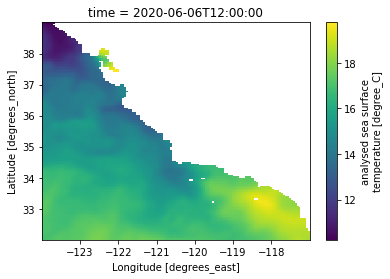

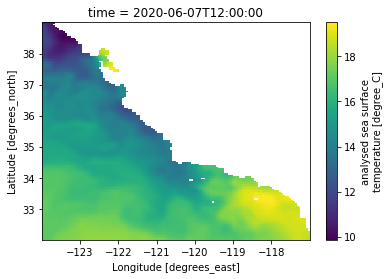

In [14]:
import matplotlib.pyplot as plt

for i in range(0,5):
    ax = plt.subplot()
    sst.isel(time=i).plot.imshow()
    plt.show()

## Calculate the mean SST over the region for each day 
* Use the matplotlib.pyplot.plot_date() plot routine, which formats the x axis labels as dates
* Input sst.time as the x axis values
* Use the numpy mean() method to take the mean of the latitude longitude grid ( axis=(1,2) ) for each time slice.

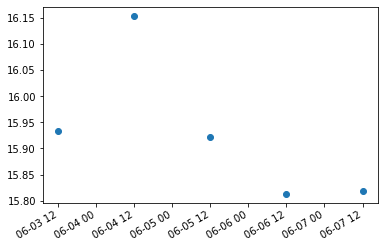

In [18]:
plt.plot_date(sst.time, sst.mean(axis=(1,2)), 'o')

# auto format the date label positions on the x axis
plt.gcf().autofmt_xdate()

# Appendix

## Installation instruction are at these links
pandas: https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html   
numpy: https://numpy.org/install/  
xarray: http://xarray.pydata.org/en/latest/getting-started-guide/installing.html 